# The Battle of Neighborhoods

## Study about Chinese Restaurants in New York

Importing the required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy
import os


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Defining a function to get the latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Defining a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. The function will return us the venue id , venue name and category.

In [3]:
#Setting variables
radius=1000
LIMIT=100
CLIENT_ID = 'AHO0SVBOQ2TQJOVT5XUTB5GAD0V3MJH1CK3ZVS3RMS44CQL2' # your Foursquare ID
CLIENT_SECRET = 'SBL5SDXTEVK3CIZYBK4FCUYXDITCJC0MT3EZOXNJDD4XWZQE' # your Foursquare Secret
VERSION = '20200420' # Foursquare API version

In [4]:
def get_venues(lat,lng):
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Defining a function to get venue details like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Getting the data about Boroughs, Neighborhoods with their latitudes and longitudes of New York City

In [6]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
# all data is present in features label
features=resp['features']
    
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)
 
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                        'Neighborhood': neighborhood_name,
                                        'Latitude': neighborhood_lat,
                                        'Longitude': neighborhood_lon},
                                        ignore_index=True)

In [7]:
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
new_york_data.shape

(306, 4)

Lets show how many different Neighborhoods have in New york

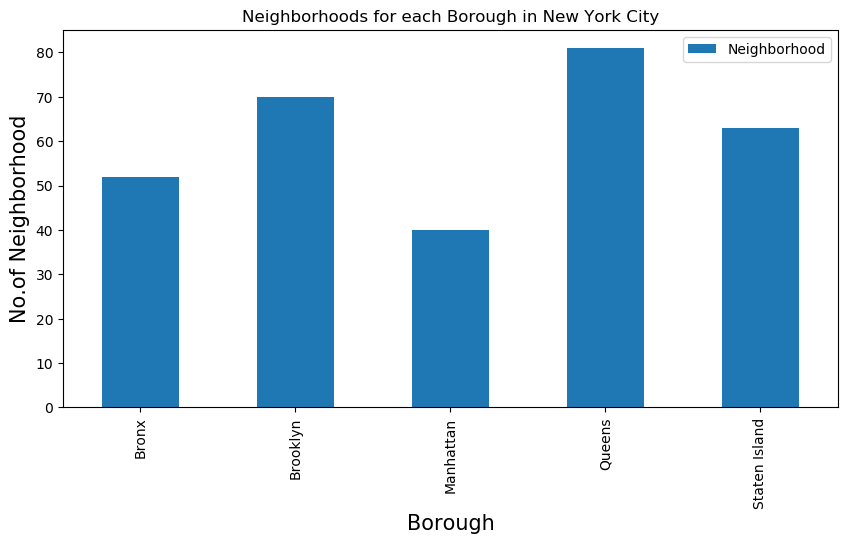

In [9]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now, lets collect the Chinese Restaurant for each Neighborhood

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names = ['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny = pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    for restaurant_detail in chinese_restaurants.values.tolist():
        id, name , category = restaurant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [12]:
chinese_rest_ny.shape

(401, 4)

In [15]:
chinese_rest_ny.to_csv('ChineseRestaurants.csv',index=False)

Now, lets see the Number of Chinese Restaurants for each Borough in New York

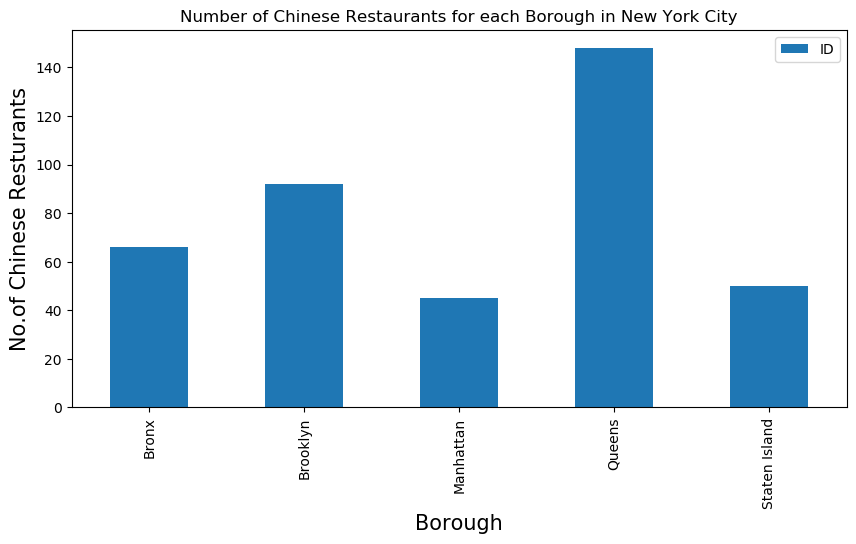

In [16]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Getting the rank of each restaurant

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_details_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_details_ny = chinese_rest_details_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [35]:
chinese_rest_details_ny.head()

Borough Neighborhood                        ID            Name Likes Rating  \
0   Bronx    Wakefield                         0               0     0      0   
1   Bronx   Co-op City                         0               0     0      0   
2   Bronx   Co-op City  4c66dcfaaebea593955a74d0  Chinese Buffet     7    4.9   
3   Bronx  Eastchester                         0               0     0      0   
4   Bronx    Fieldston                         0               0     0      0   

  Tips  
0    0  
1    0  
2   10  
3    0  
4    0

In [38]:
chinese_rest_details_ny.shape

(401, 7)

In [39]:
chinese_rest_details_ny.to_csv('ChineseRestaurantsDetails.csv',index=False)

In [41]:
chinese_rest_details_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 7 columns):
Borough         401 non-null object
Neighborhood    401 non-null object
ID              401 non-null object
Name            401 non-null object
Likes           401 non-null object
Rating          401 non-null object
Tips            401 non-null object
dtypes: object(7)
memory usage: 22.1+ KB


Changing the Data types of the coluns Likes, Tips and Rating to float for analysis

In [42]:
chinese_rest_details_ny['Likes']=chinese_rest_details_ny['Likes'].astype('float64')
chinese_rest_details_ny['Tips']=chinese_rest_details_ny['Tips'].astype('float64')
chinese_rest_details_ny['Rating']=chinese_rest_details_ny['Rating'].astype('float64')

Finding the best Chinese Restaurants by Likes

In [71]:
chinese_rest_details_ny.loc[chinese_rest_details_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               9.2
Tips                                 521
Name: 148, dtype: object

Finding the best Chinese Restaurants by Rating

In [73]:
chinese_rest_details_ny.loc[chinese_rest_details_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               9.2
Tips                                 521
Name: 148, dtype: object

Lets exclude all restaurants that didnt have any Like or Rating yet from the calculations

In [74]:
chinese = chinese_rest_details_ny[chinese_rest_details_ny['Likes'] > 0 ]
chinese.reset_index(inplace=True)
chinese.drop('index',axis=1,inplace=True)
chinese.head()

Borough    Neighborhood                        ID  \
0   Bronx      Co-op City  4c66dcfaaebea593955a74d0   
1   Bronx         Norwood  4e2e08021838f1c552b6b8eb   
2   Bronx         Norwood  4e4d0387bd413c4cc66dfd72   
3   Bronx      Baychester  4c1a8bac8b3aa593a8c8955f   
4   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   

                             Name  Likes  Rating  Tips  
0                  Chinese Buffet    7.0     4.9  10.0  
1  Choi Yuan - Chinese Restaurant    6.0     6.9   7.0  
2    Hung Hing Chinese Restaurant    5.0     5.9   2.0  
3                     Dragon City    1.0     6.9   8.0  
4      Mr. Q's Chinese Restaurant    9.0     7.4  10.0

Now, lets visualize the average rating of each neighborhood restaurants

In [89]:
chinese_neigh = chinese.groupby('Neighborhood',as_index = False)[['Likes','Rating']].mean()
chinese_neigh.sort_values(['Rating'],ascending=False)

Neighborhood        Likes    Rating
20                     Chelsea  1487.000000  9.200000
55                  Greenpoint   396.000000  9.100000
90                  North Side   341.000000  9.000000
87                 Murray Hill  1045.000000  8.900000
24                Civic Center   104.000000  8.900000
84               Midtown South  1045.000000  8.900000
83                     Midtown  1045.000000  8.900000
123               West Village   191.500000  8.900000
73                Little Italy   302.000000  8.800000
118            Upper West Side   395.500000  8.800000
75             Lower East Side    37.500000  8.750000
80                 Marine Park    58.000000  8.700000
116                    Tribeca   353.000000  8.700000
109                 South Side   188.500000  8.600000
125               Williamsburg   188.500000  8.600000
34                    Downtown    94.500000  8.550000
12                 Boerum Hill    94.500000  8.550000
21                   Chinatown   351.800000  8.420000
128                   Woodside    25.500000  8.350000
107                      Rugby    31.000000  8.300000
50                    Gramercy    20.000000  8.300000
104                  Rego Park    19.000000  8.200000
70                 Lefrak City    19.000000  8.200000
77            Manhattan Valley    88.500000  8.175000
6                    Bayswater    13.000000  8.100000
86         Morningside Heights    16.750000  8.025000
98   Prospect Lefferts Gardens     5.000000  7.900000
44                    Flushing    64.250000  7.856250
39                    Elmhurst    26.000000  7.850000
78              Manhattanville     9.000000  7.800000
57            Hamilton Heights    52.000000  7.800000
35               Dyker Heights    20.000000  7.800000
47               Fort Hamilton    20.000000  7.800000
19              Central Harlem     9.500000  7.750000
129                  Yorkville     9.000000  7.700000
25                Clinton Hill   110.000000  7.700000
71                  Lenox Hill    13.000000  7.700000
2                    Bay Ridge    20.666667  7.666667
32                Dongan Hills    23.000000  7.600000
69         Kingsbridge Heights    12.000000  7.600000
60                   Hillcrest     6.000000  7.600000
115               Sutton Place   153.000000  7.600000
45                     Fordham    12.000000  7.600000
74                 Little Neck    50.750000  7.575000
41                Far Rockaway    10.000000  7.550000
36                 East Harlem     7.000000  7.500000
27               College Point    39.500000  7.500000
103                 Ravenswood    29.500000  7.500000
113          Sunnyside Gardens     7.000000  7.500000
122              West Brighton     3.000000  7.500000
95              Pelham Parkway     9.000000  7.400000
72                  Lindenwood    18.000000  7.400000
97               Port Richmond     6.000000  7.400000
106                  Ridgewood     7.500000  7.400000
111                   Steinway     8.000000  7.400000
121                 Weeksville    10.500000  7.400000
59                High  Bridge     5.000000  7.400000
0              Astoria Heights     8.000000  7.400000
28                   Concourse     5.000000  7.400000
51                Graniteville     5.000000  7.400000
33                  Douglaston    57.000000  7.400000
10                 Bensonhurst    14.000000  7.400000
114                Sunset Park    33.600000  7.380000
127            Windsor Terrace    71.000000  7.350000
16                  Bulls Head    21.500000  7.350000
15                   Bronxdale     8.000000  7.333333
99         Prospect Park South     4.000000  7.300000
53                   Gravesend     5.000000  7.300000
61                   Homecrest    17.000000  7.200000
68           Kew Gardens Hills     6.000000  7.200000
92             Oakland Gardens     8.500000  7.200000
8           Bedford Stuyvesant    11.333333  7.166667
117                  Unionport     6.000000  7.100000
94                 Par

And now, for each Borough

In [90]:
chinese_borou = chinese.groupby('Borough',as_index = False)[['Likes','Rating']].mean()
chinese_borou.sort_values(['Rating'],ascending=False)

Borough       Likes    Rating
2      Manhattan  216.840909  8.163636
1       Brooklyn   46.213115  7.457377
3         Queens   27.055556  7.186667
4  Staten Island    8.217391  6.934783
0          Bronx    7.150000  6.830000

Lets join the dataset off Neighborhood Average with the orginal New York Data to get latitude and longitude

In [91]:
chinese_cluster = pd.merge(chinese_neigh,new_york_data,on='Neighborhood')

Cleaning the duplicate values for Neighborhood that are in more than one Borough

In [101]:
chinese_cluster = chinese_cluster.drop_duplicates(['Neighborhood'])

Droping the Like column

In [ ]:
chinese_cluster.drop('Likes',axis=1,inplace=True)

In [102]:
chinese_cluster

Neighborhood        Likes    Rating        Borough  \
0              Astoria Heights     8.000000  7.400000         Queens   
1                   Bath Beach    12.333333  6.933333       Brooklyn   
2                    Bay Ridge    20.666667  7.666667       Brooklyn   
3                  Bay Terrace     9.000000  6.650000         Queens   
5                   Baychester     1.000000  6.900000          Bronx   
6                      Bayside     1.000000  7.100000         Queens   
7                    Bayswater    13.000000  8.100000         Queens   
8                 Bedford Park     5.500000  6.400000          Bronx   
9           Bedford Stuyvesant    11.333333  7.166667       Brooklyn   
10                    Bellaire     4.000000  6.200000         Queens   
11                 Bensonhurst    14.000000  7.400000       Brooklyn   
12                  Blissville    16.000000  6.550000         Queens   
13                 Boerum Hill    94.500000  8.550000       Brooklyn   
14                   Briarwood     7.500000  6.850000         Queens   
15           Broadway Junction     6.000000  7.000000       Brooklyn   
16                   Bronxdale     8.000000  7.333333          Bronx   
17                  Bulls Head    21.500000  7.350000  Staten Island   
18             Cambria Heights     4.000000  5.700000         Queens   
19           Castleton Corners     6.000000  7.000000  Staten Island   
20              Central Harlem     9.500000  7.750000      Manhattan   
21                     Chelsea  1487.000000  9.200000      Manhattan   
23                   Chinatown   351.800000  8.420000      Manhattan   
24                 City Island     6.000000  6.300000          Bronx   
25                   City Line     5.000000  6.800000       Brooklyn   
26                Civic Center   104.000000  8.900000      Manhattan   
27                Clinton Hill   110.000000  7.700000       Brooklyn   
28                  Co-op City     7.000000  4.900000          Bronx   
29               College Point    39.500000  7.500000         Queens   
30                   Concourse     5.000000  7.400000          Bronx   
31           Concourse Village    12.000000  6.800000          Bronx   
32                Coney Island     4.000000  6.600000       Brooklyn   
33                 Ditmas Park     3.000000  6.700000       Brooklyn   
34                Dongan Hills    23.000000  7.600000  Staten Island   
35                  Douglaston    57.000000  7.400000         Queens   
36                    Downtown    94.500000  8.550000       Brooklyn   
37               Dyker Heights    20.000000  7.800000       Brooklyn   
38                 East Harlem     7.000000  7.500000      Manhattan   
39               East New York     5.000000  6.800000       Brooklyn   
40                    Elm Park     6.000000  7.066667  Staten Island   
41                    Elmhurst    26.000000  7.850000         Queens   
42                     Erasmus     3.000000  6.700000       Brooklyn   
43                Far Rockaway    10.000000  7.550000         Queens   
44                    Flatbush     3.000000  6.700000       Brooklyn   
45                   Flatlands     9.000000  6.100000       Brooklyn   
46                    Flushing    64.250000  7.856250         Queens   
47                     Fordham    12.000000  7.600000          Bronx   
48                Forest Hills    11.500000  6.650000         Queens   
49               Fort Hamilton    20.000000  7.800000       Brooklyn   
50               Fresh Meadows     5.250000  5.925000         Queens   
51                  Georgetown     7.000000  6.450000       Brooklyn   
52                    Gramercy    20.000000  8.300000      Manhattan   
53                Graniteville     5.000000  7.400000  Staten Island   
54                  Grant City     9.000000  5.600000  Staten Island   
55                   Gravesend     5.000000  7.300000       Brooklyn   
56                 Great Kills     7.000000  6.500000  Sta

Now, lets visualize the Rating Neighborhoods in a Choropleth Map

In [151]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

ny_geo = r'Neighborhood Tabulation Areas (NTA).geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=chinese_cluster,
    columns=['Neighborhood', 'Rating'],
    key_on='feature.properties.ntaname',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('neighbor_rating.html')
ny_map

 Clustering Neighborhoods by Likes and Rating

Run k-means to cluster the neighborhood into 3 clusters.

In [115]:
k_chinese = chinese_cluster.drop(['Neighborhood', 'Latitude','Longitude','Borough'],1)

In [164]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(k_chinese)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [165]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster for each neighborhood

In [167]:
# add clustering labels
chinese_cluster.drop('Cluster Labels', 1,inplace=True)
chinese_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

chinese_cluster.head()

C:\Users\muril\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Cluster Labels     Neighborhood      Likes    Rating   Borough   Latitude  \
0               0  Astoria Heights   8.000000  7.400000    Queens  40.770317   
1               0       Bath Beach  12.333333  6.933333  Brooklyn  40.599519   
2               0        Bay Ridge  20.666667  7.666667  Brooklyn  40.625801   
3               0      Bay Terrace   9.000000  6.650000    Queens  40.782843   
5               0       Baychester   1.000000  6.900000     Bronx  40.866858   

   Longitude  
0 -73.894680  
1 -73.998752  
2 -74.030621  
3 -73.776802  
5 -73.835798

Finally, let's visualize the resulting clusters

In [168]:
# create map
map_clusters = folium.Map(location=geo_location('New York'), zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chinese_cluster['Latitude'], chinese_cluster['Longitude'], chinese_cluster['Neighborhood'],
                                  chinese_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examining Clusters

In [172]:
chinese_cluster.loc[chinese_cluster['Cluster Labels'] == 0,['Rating','Likes']].mean()

Rating     7.133358
Likes     18.006078
dtype: float64

In [173]:
chinese_cluster.loc[chinese_cluster['Cluster Labels'] == 1,['Rating','Likes']].mean()

Rating       8.975
Likes     1155.500
dtype: float64

In [174]:
chinese_cluster.loc[chinese_cluster['Cluster Labels'] == 2,['Rating','Likes']].mean()

Rating      8.768889
Likes     300.866667
dtype: float64